# Lab1. Prepare license plate image and annotation data

In this lab, you will generate 10,000 Korean number plate image annotation files for our training.  
* Before running, **Maker sure you have enough local storage to store traing images (20+GB)**
* Core idea and script of this data generation was quoted from Matthew's blog ([here](https://matthewearl.github.io/2016/05/06/cnn-anpr/))
* You may adjust the number of image to 1,000, 5,000, etc. for more fast processing
* You may adjust the number of image to 50,000, 100,000, etc. for more accuracy
* You may run all cells bellow at once

## Set up dependencies

In [13]:
import sys
!{sys.executable} -m pip install opencv-python image matplotlib 

  Running setup.py bdist_wheel for pickle-mixin ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from PIL import Image
import os

## Download background images
- **It may take 4~5 minutes** to download and extract images
- SUN dataset(https://vision.princeton.edu/projects/2010/SUN/) were used

In [9]:
if os.path.exists('bgs.tar.gz')==False:
    !wget https://s3.ap-northeast-2.amazonaws.com/leon-shared/bgs/bgs.tar.gz
    !tar -zxvf bgs.tar.gz |grep ".jpg" |wc -l
bgs = os.listdir('bgs')
print("{} images were downloaded.".format(len(bgs)))

108634
108635 images were downloaded.


In [3]:
!rm -fR gen #gen-imgs gen-tags cropped-imgs nums-tags
!mkdir gen gen/gen-imgs gen/gen-tags gen/cropped-imgs gen/nums-tags
!chmod 755 gen-w-bbx.py

## Generate training images and tags
* Execute gen-w-bbx.py as the argument of 10,000 number of sample images (You can change the number of sample images)
* This code will generate 10,000 Korean license plate sample images in the below folders
    * gen/gen-imgs: Arbitrary Korean license plate images
    * gen/gen-tags: The position(cordinates) of license plate in the image
    * gen/cropped-imgs: License-plate-cropped images from generated trining imaged
    * gen/nums-tags: Json files to record the character of license plate as list
* **It may take 10+ minutes if you generate 100,000+ images**

In [5]:
num_of_images = None #10000 #Set the number of images as 1000~100000
assert num_of_images != None

In [6]:
%run gen-w-bbx.py {num_of_images}

00000000_09_7779_0
00000001_46_2707_1
00000002_99_9594_1
00000003_20_6910_0
00000004_78_9630_0
00000005_94_5511_1
00000006_95_2479_1
00000007_25_9548_1
00000008_91_7719_1
00000009_18_1316_1
... 10000 images and tags were generated


## Check the result of data generation

* Define bounding box visualization function

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def visualize_detection(img_file, dets, code, thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.image as mpimg

        img=img_file
        plt.imshow(img)
        height = img.size[0]
        width = img.size[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0
            ymin = y0
            xmax = x1
            ymax = y1
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(code, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

* Check the number of images

In [8]:
print(len(os.listdir('gen/gen-imgs')))
print(len(os.listdir('gen/cropped-imgs')))

10000
10000


* Sample 10 reuslts

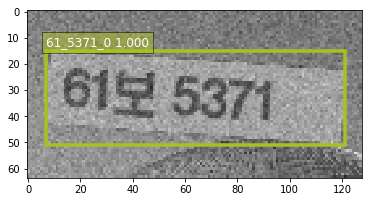

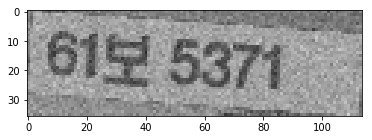

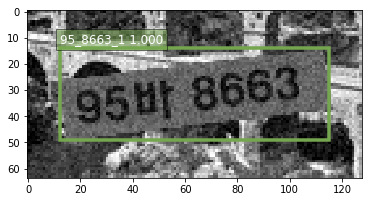

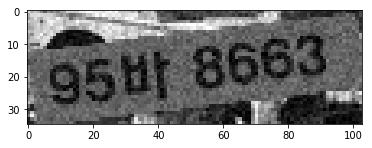

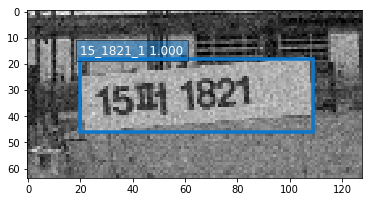

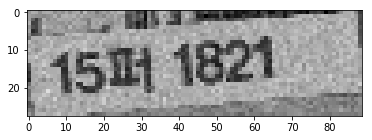

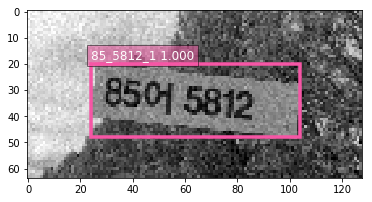

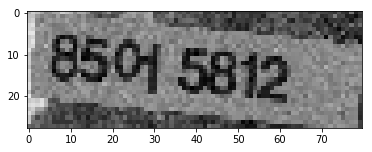

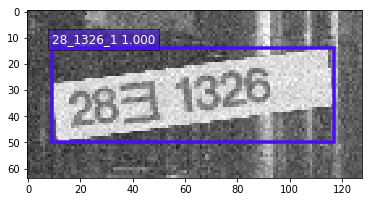

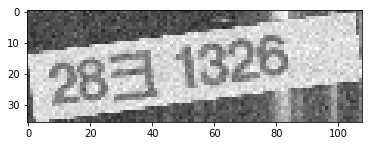

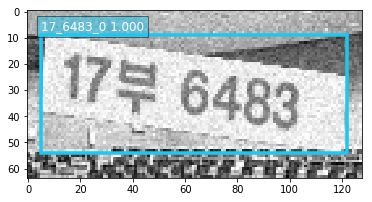

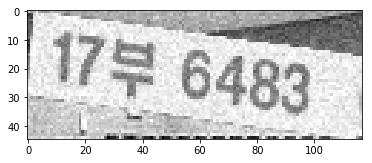

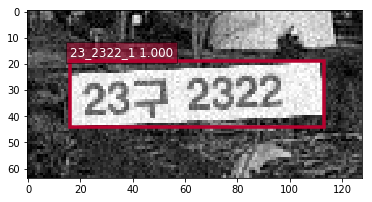

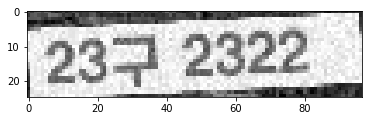

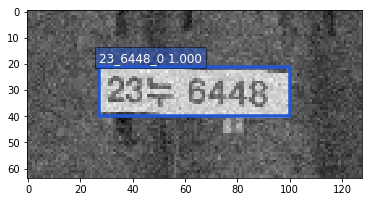

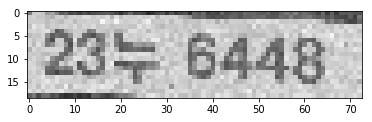

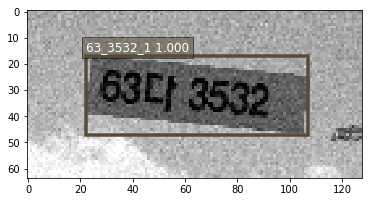

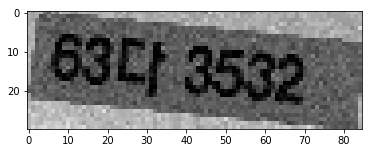

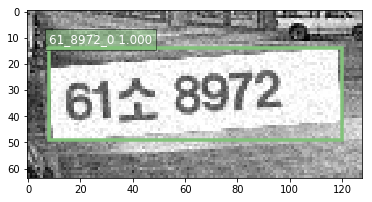

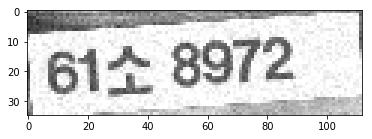

In [9]:
jsons = os.listdir('gen/gen-tags')
classes=['plate']
for i in jsons[0:10]:
    ext = os.path.splitext(i)[-1]
    if ext == '.json':
        jname = str('gen/gen-tags/') + i
        with open(jname, 'r') as jsonfile:  
                readjson = json.load(jsonfile) 
                iname = str('gen/gen-imgs/') + readjson['file']
                img=Image.open(iname)

                rx1=readjson['annotations'][0]['left']
                ry1=readjson['annotations'][0]['top']
                rx2=readjson['annotations'][0]['left']+ readjson['annotations'][0]['width']
                ry2=readjson['annotations'][0]['top']+ readjson['annotations'][0]['height']
                code=readjson['file'][9:18]
                dets = [['0', 1.0, rx1, ry1, rx2, ry2]]
                visualize_detection(img, dets, code)

                cimgname = str('gen/cropped-imgs/') + os.path.splitext(i)[0] + str('.png')
                cropped = Image.open(cimgname)
                plt.imshow(cropped)
                plt.show()

## Check annotation files

* Check the file format of annotation file for object detection

In [10]:
gen_tag = os.listdir('gen/gen-tags')[0]
with open('gen/gen-tags/' + gen_tag, 'r') as jfile:
    print(json.dumps(json.load(jfile), indent=4))

{
    "file": "00007227_61_5371_0.png",
    "image_size": [
        {
            "width": 128,
            "height": 64,
            "depth": 3
        }
    ],
    "annotations": [
        {
            "class_id": "0",
            "left": 7,
            "top": 15,
            "width": 114,
            "height": 36
        }
    ],
    "categories": [
        {
            "class_id": 0,
            "name": "License Plate"
        }
    ]
}


## Check nums-tags files

* Check the file format of nums-tags file for OCR with CNN
* Real character of license plate can be found with nums index in JOIN list

In [11]:
NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE

In [12]:
nums_tag = os.listdir('gen/nums-tags')[0]
with open('gen/nums-tags/' + nums_tag, 'r') as jfile:
    n_tag = json.load(jfile)
    print(json.dumps(n_tag, indent=4))

for id in n_tag['nums']: print(JOIN[id]) 

{
    "file": "00007227_61_5371_0.png",
    "nums": [
        5,
        0,
        38,
        4,
        2,
        6,
        0
    ]
}
6
1
보
5
3
7
1
